In this notebook, we determine data-driven synonyms for the German terms 'Konjunktur' (translating to 'business cycle conditions') and 'Wirtschaft' (translating to 'economy') that exhibit close semantic and syntactic properties to these words of interest. We do this by implementing and comparing two distinct methodologies.

1. The first approach is inspired by the work of [Soto (2021)](https://link.springer.com/article/10.1007/s10693-020-00338-5) and involves clustering 256-dimensional word vectors using the K-means clustering algorithm. Here, we consider the words located in the same cluster as 'Konjunktur' or 'Wirtschaft' to be their respective synonyms. To manage computational costs, we focus on a subset of 1000 words that display the highest degree of cosine similarity to our target words instead of clustering the entire vocabulary in our corpus. The optimal number of clusters is determined using the Silhouette score as a performance metric, adjusting the cluster count to maximize within-cluster similarity and minimize between-cluster similarity.

2. The second approach is simpler and directly identifies synonyms by selecting the top N words that are most cosine-similar to 'Konjunktur' or 'Wirtschaft'.

Each of these strategies is executed independently, and we compare the identified synonyms from both methods. Ultimately, we choose the approach that yields the most reasonable and contextually relevant synonyms for 'Konjunktur' and 'Wirtschaft'. This comparison of methodologies allows us to ensure a more robust and effective synonym identification process.

In our article, we refer to the data-driven synonyms identified in this notebook as "terms related to business cycle conditions" because this terminology is more precise. While we consider the words that are cosine similar to the embeddings of 'business cycle conditions' or 'economy' to be data-driven synonyms, it’s important to note that most of these terms are not exact synonyms in the traditional sense. Instead, these words frequently appear in similar contexts as 'business cycle conditions' and 'economy', reflecting their close semantic relationship. 

---

We begin by loading pre-estimated word vectors. These 256-dimensional word vectors were estimated using the Word2Vec algorithm, as detailed in the `word2vec_estimation` notebook.

In [1]:
import numpy as np
from datetime import datetime

# Specify the file path
filepath = 'news_word2vec.txt'

# Count the number of lines in the file to ascertain the number of word embeddings
with open(filepath, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        pass
    
n_lines = i + 1  # Total number of lines
print(f'Total number of lines (word embeddings): {n_lines}')

Total number of lines (word embeddings): 757990


In [2]:
# Initialize the word and embedding arrays
words_read = []
embeddings_read = np.zeros((n_lines,256), dtype = np.float32)

# Track time
startTime = datetime.now()

# Open the file and read in the embeddings line by line
with open(filepath, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        tokens = line.rstrip().split(' ')
        words_read.append(tokens[0])
        embeddings_read[i] = np.array(tokens[1:], dtype = np.float32)

print(f'Time taken: {datetime.now()-startTime}')

# Create int_to_vocab and vocab_to_int dictionaries
int_to_vocab = {ii: word for ii, word in enumerate(words_read)}
vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

Time taken: 0:01:06.200507


We begin by calculating the cosine similarity between the word embeddings for 'Konjunktur' and 'Wirtschaft' and the embeddings for all other words in our vocabulary. This measure provides an indication of how similar the semantic context of each word is to our terms of interest. The calculation of cosine similarity is an important step for both methodologies used to find data-driven synonyms. 

Following this, for our first methodology, we identify the top 1000 words that exhibit the highest cosine similarity to either 'Konjunktur' or 'Wirtschaft'. These selected words are deemed as synonym candidates for our two terms of interest, as their high cosine similarity implies a close semantic relationship.

In [3]:
def get_synonym_candidates(word, vocab, embeddings, num_synonyms, int_to_v):
    
    """
    This function returns top-k closest words for the given word based on cosine similarity.

    :param word: word to find synonyms for
    :param vocab: vocabulary dictionary with word to int mapping
    :param embeddings: word embeddings matrix
    :param num_synonyms: number of synonym candidates to retrieve
    :param int_to_vocab: dictionary with int to word mapping
    :return: a list of closest words
    """
    # Ensure the word is present in the vocabulary
    if word not in vocab:
        print(f"Word {word} not in vocabulary")
        return
    
    # Retrieve the corresponding id
    word_id = vocab[word]
    
    # Calculate magnitudes of embedding vectors
    magnitudes = np.sqrt(np.square(embeddings).sum(axis=1))
    
    # Retrieve embedding for the word of interest
    word_vector = embeddings[word_id]
    
    # Compute (almost) cosine similarity between word of interest and all the embeddings
    similarities = np.matmul(word_vector, np.transpose(embeddings))/magnitudes
    
    # Get indices corresponding to the top-k closest words
    closest_indices = similarities.argsort()[-num_synonyms:]
    
    # Retrieve and return top-k closest words in descending order of similarity
    closest_words = [int_to_vocab[idx] for idx in closest_indices[::-1]]

    return closest_words

In [4]:
# Retrieve the top 1000 words in the vocabulary that are closest to the word 'konjunktur'
candidates_konjunktur = get_synonym_candidates('konjunktur', vocab_to_int, embeddings_read, 1000, int_to_vocab)

# Retrieve the top 1000 words in the vocabulary that are closest to the word 'wirtschaft'
candidates_wirtschaft = get_synonym_candidates('wirtschaft', vocab_to_int, embeddings_read, 1000, int_to_vocab)

In [5]:
# Convert synonym candidates of 'konjunktur' to their corresponding integer values
candidates_konjunktur_int = np.array([vocab_to_int[word] for word in candidates_konjunktur])
# Retrieve the corresponding word embeddings
candidates_konjunktur_emb = embeddings_read[candidates_konjunktur_int]

# Convert synonym candidates of 'wirtschaft' to their corresponding integer values
candidates_wirtschaft_int = np.array([vocab_to_int[word] for word in candidates_wirtschaft])
# Retrieve the corresponding word embeddings
candidates_wirtschaft_emb = embeddings_read[candidates_wirtschaft_int]

Building on our prior steps, we now proceed with the first approach, involving the use of the K-means clustering algorithm to generate data-driven synonyms for the terms  'Konjunktur' and 'Wirtschaft'. This involves clustering the 256-dimensional word embeddings we have previously prepared for the synonym candidates.

A crucial aspect in the use of K-means clustering involves determining the optimal number of clusters, as this can significantly impact the outcome and quality of our clusters. To objectively select this number, we employ the Silhouette score as a measure of the quality of the clustering.

In [6]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

# Define the range of potential cluster sizes to evaluate
possible_k_values = range(2, 25, 1)

def silhouette_k(k, data):
    """
    Function to calculate the silhouette score for a given number of clusters.
    """
    # Create a kmeans model for 'k' clusters
    kmeans = KMeans(n_clusters=k, n_init=10).fit(data)
    
    # Predict the cluster for each data point
    predictions = kmeans.predict(data)
    
    # Calculate and return the average silhouette score
    silhouette_avg = silhouette_score(data, predictions)
    
    return silhouette_avg

# Calculate the silhouette score for each potential cluster size
silhouette_per_k = [silhouette_k(k, candidates_konjunktur_emb) for k in possible_k_values]

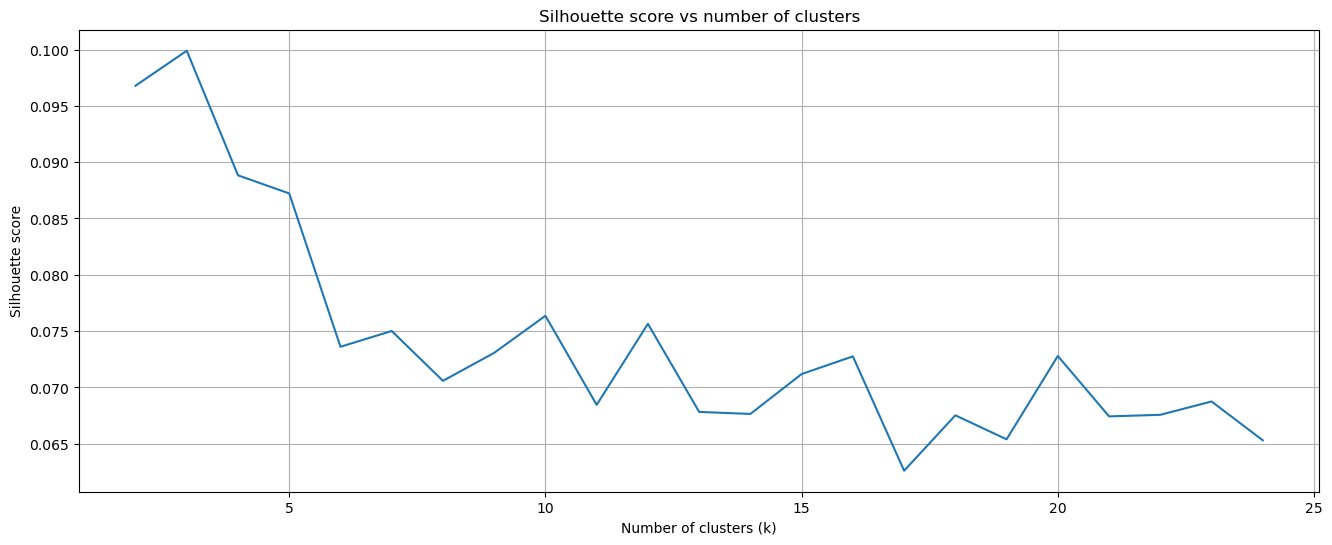

In [7]:
# Plot the silhouette scores against k values
plt.figure(figsize=(16, 6))
plt.plot(possible_k_values, silhouette_per_k)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.grid(True)
plt.show()

In [8]:
# Get the optimal number of clusters by finding the 'k' value that gives the highest silhouette score
optimal_k = possible_k_values[np.argmax(silhouette_per_k)]
print(f'Optimal number of clusters: {optimal_k}')

Optimal number of clusters: 3


In [9]:
# Create a new kmeans model with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, n_init=10).fit(candidates_konjunktur_emb)

# Get the cluster predictions for the data
predictions_optimal = kmeans_optimal.predict(candidates_konjunktur_emb)

# Create a dictionary mapping from word index to its assigned cluster
index_to_cluster = dict(zip(candidates_konjunktur_int, predictions_optimal))

# Find the cluster that contains the word 'Konjunktur'
konjunktur_cluster = index_to_cluster[vocab_to_int['konjunktur']]

# Get all words that belong to the 'konjunktur' cluster
konjunktur_synonyms = [int_to_vocab[idx] for idx, cluster in index_to_cluster.items() if cluster == konjunktur_cluster]

# Print out the number of synonyms
print("Number of synonyms:", len(konjunktur_synonyms))

# Print out the synonyms
print(f'Synonyms for konjunktur: {konjunktur_synonyms}')

Number of synonyms: 279
Synonyms for konjunktur: ['konjunktur', 'aufschwung', 'konjunkturelle', 'konjunkturaufschwung', 'aufschwungs', 'konjunkturellen', 'binnennachfrage', 'konjunkturbelebung', 'binnenkonjunktur', 'konjunktureller', 'konjunkturlage', 'anspringen', 'konjunkturmotor', 'wachstumsschwäche', 'konjunkturell', 'konjunkturforscher', 'konsumnachfrage', 'inlandsnachfrage', 'konsum', 'konjunkturprognosen', 'wirtschaftswachstum', 'wirtschaftsentwicklung', 'wirtschaftsforscher', 'gesamtwirtschaft', 'gesamtwirtschaftliche', 'wirtschaftsaufschwung', 'wirtschaftswachstums', 'konsums', 'konjunkturexperten', 'binnenwirtschaft', 'konjunkturverlauf', 'konjunkturaufschwungs', 'investitionstätigkeit', 'wachstumsprognose', 'wachstumspfad', 'wachstumsdynamik', 'konjunkturprognose', 'ifoinstitut', 'lahmende', 'ausrüstungsinvestitionen', 'dämpfen', 'reales', 'ifoinstituts', 'ifo', 'konjunkturprogramme', 'investitionsneigung', 'exportwirtschaft', 'dynamik', 'wirtschaftsforschungsinstitute', 'wi

Having generated 279 synonyms for 'Konjunktur' using Soto's methodology, we now turn our attention to our second approach. This simpler method will focus on the 200 words exhibiting the highest cosine similarity with 'Konjunktur'. By comparing the synonyms obtained from both methodologies, we aim to identify the approach that provides more contextually accurate and relevant synonyms for our term of interest.

In [10]:
# Determine the 200 words with the highest cosine similarity to 'Konjunktur'
konjunktur_synonyms_cosine_similarity = candidates_konjunktur[:200]

# Print out the number of synonyms
print("Number of synonyms:", len(konjunktur_synonyms_cosine_similarity))

# Print out the synonyms
print(f'Synonyms for konjunktur: {konjunktur_synonyms_cosine_similarity}')

Number of synonyms: 200
Synonyms for konjunktur: ['konjunktur', 'aufschwung', 'konjunkturelle', 'konjunkturaufschwung', 'aufschwungs', 'konjunkturellen', 'binnennachfrage', 'konjunkturbelebung', 'binnenkonjunktur', 'konjunkturentwicklung', 'konjunktureller', 'abschwung', 'rezession', 'konjunkturlage', 'anspringen', 'konjunkturmotor', 'wachstumsschwäche', 'konjunkturerholung', 'weltkonjunktur', 'belebung', 'stagnation', 'konjunkturell', 'konjunkturforscher', 'konjunktureinbruch', 'konsumnachfrage', 'inlandsnachfrage', 'konsum', 'konjunkturaussichten', 'konjunkturprognosen', 'wirtschaftswachstum', 'spürbar', 'wachstumsprognosen', 'abschwungs', 'konjunkturschwäche', 'wirtschaftsentwicklung', 'wirtschaftsforscher', 'gesamtwirtschaft', 'gesamtwirtschaftliche', 'wirtschaftsaufschwung', 'wirtschaftswachstums', 'konsums', 'wachstumserwartungen', 'konjunkturexperten', 'binnenwirtschaft', 'konjunkturverlauf', 'abschwächen', 'eintrübung', 'anziehen', 'trendwende', 'konjunkturaufschwungs', 'invest

To thoroughly compare our two methodologies, we begin by pinpointing the common elements across both lists of synonyms, representing words identified as similar to 'Konjunktur' by both methods. This intersection presents us with a set of synonyms that are consistently identified, irrespective of the approach utilized.

In [11]:
# Convert the lists to sets
set_konjunktur_synonyms = set(konjunktur_synonyms)
set_konjunktur_synonyms_cosine_similarity = set(konjunktur_synonyms_cosine_similarity)

# Find the intersection of the two sets
common_synonyms = set_konjunktur_synonyms.intersection(set_konjunktur_synonyms_cosine_similarity)

# Convert the intersection set back to a list
common_synonyms = list(common_synonyms)

# Print out the common synonyms
print(f'Common synonyms for "Konjunktur": {common_synonyms}')

Common synonyms for "Konjunktur": ['konjunkturdelle', 'konjunkturprognose', 'dämpfenden', 'konjunktur', 'aufschwungs', 'binnenwirtschaft', 'ifoinstituts', 'dämpfen', 'ifw', 'investitionstätigkeit', 'konjunkturexperten', 'sparquote', 'expansiven', 'unternehmensinvestitionen', 'ökonomen', 'konjunkturstütze', 'konjunkturaufschwungs', 'realen', 'binnennachfrage', 'wirtschaftsforschungsinstitute', 'gesamtwirtschaftliche', 'weltwirtschaft', 'lohnabschlüsse', 'anspringen', 'aufschwung', 'wirtschaftslage', 'stimulieren', 'konsums', 'schrumpfung', 'lahmende', 'konjunktureller', 'konjunkturlokomotive', 'bruttoinlandsprodukt', 'investitionsbereitschaft', 'konjunkturprognosen', 'ausrüstungsinvestitionen', 'gesamtwirtschaft', 'konjunkturmotor', 'reales', 'expansive', 'wirtschaftsentwicklung', 'reale', 'wirtschaftsleistung', 'weltwirtschaftlichen', 'wachstumsprognose', 'beschäftigungslage', 'wirtschaftswachstum', 'wachstumspfad', 'investitionsneigung', 'ifo', 'konjunkturellen', 'herbstgutachten', 'v

Following this, we distinguish the unique elements in each list, which are the synonyms that were exclusively identified by one methodology. This examination allows us to compare and evaluate the performance and accuracy of the Soto-inspired clustering method and the simpler cosine similarity approach in identifying relevant synonyms.

In [12]:
# Unique synonyms for the first list
unique_konjunktur_synonyms = list(set_konjunktur_synonyms - set_konjunktur_synonyms_cosine_similarity)
print(f'Unique synonyms for "Konjunktur" from the first method: {unique_konjunktur_synonyms}')

# Unique synonyms for the second list
unique_konjunktur_synonyms_cosine_similarity = list(set_konjunktur_synonyms_cosine_similarity - set_konjunktur_synonyms)
print(f'Unique synonyms for "Konjunktur" from the second method: {unique_konjunktur_synonyms_cosine_similarity}')

Unique synonyms for "Konjunktur" from the first method: ['währungsraum', 'wirtschaftsaufschwungs', 'außenhandel', 'durchgreifenden', 'exportweltmeister', 'wirtschaftsdynamik', 'beschäftigungsabbau', 'arbeitsproduktivität', 'jahresdurchschnitt', 'bip', 'eurogebiet', 'lohnabschlüssen', 'arbeitslosenquote', 'bauwirtschaft', 'wirtschaftsforschung', 'konjunkturimpulse', 'verpuffen', 'sozialprodukts', 'arbeitskosten', 'rwi', 'strukturreformen', 'konsolidierungskurs', 'wachstumsbeitrag', 'abgabenbelastung', 'kreditklemme', 'makroökonomischen', 'beschäftigungssituation', 'anzukurbeln', 'arbeitslosigkeit', 'exporte', 'gesamtwirtschaftlich', 'produktivität', 'abgekoppelt', 'steuereinnahmen', 'verschlechterung', 'investitionsklima', 'saisonbereinigte', 'arbeitsmarktentwicklung', 'verbrauchs', 'saisonbereinigten', 'lohnpolitik', 'arbeitslosenzahl', 'privatkonsum', 'verschuldung', 'struktureller', 'defizit', 'rate', 'auswirke', 'allmählichen', 'durchgreifende', 'investitionsquote', 'preisliche', 'b

Both word lists generated from our methodologies indeed relate to the concept of the 'business cycle conditions', as they include terms commonly used in discussions around economic fluctuations and trends. However, upon closer inspection, the first list – stemming from the Soto-inspired clustering methodology – appears to be more specifically related to the business cycle and its various aspects.

This list includes terms like 'stimulierung' (stimulation), 'strukturreformen' (structural reforms), 'tarifabschlüssen' (wage agreements), 'haushaltsdefizite' (budget deficits), 'investitionsschwäche' (investment weakness), 'arbeitsmarktlage' (employment situation), 'konjunkturexperte' (economic expert), and 'konjunkturprogramm' (economic program). Each of these terms is directly connected to key components of the business cycle, such as governmental policies, labor market conditions, investment tendencies, and economic performance indicators.

The second list, resulting from the cosine similarity methodology, also includes relevant terms. However, some of these terms lean towards a more general usage. For instance, 'optimistischer' (optimistic), 'anziehende' (rising), and 'kräftiger' (stronger) are not exclusively tied to the business cycle.

In [13]:
# Write the synonyms to a file
import codecs

with codecs.open("konjunktur_synonyms.txt", "w", "utf-8") as f:
    for item in konjunktur_synonyms:
        f.write("%s\n" % item)

In [14]:
# Define the range of potential cluster sizes to evaluate
possible_k_values = range(2, 25, 1)

# Calculate the silhouette score for each potential cluster size
silhouette_per_k = [silhouette_k(k, candidates_wirtschaft_emb) for k in possible_k_values]

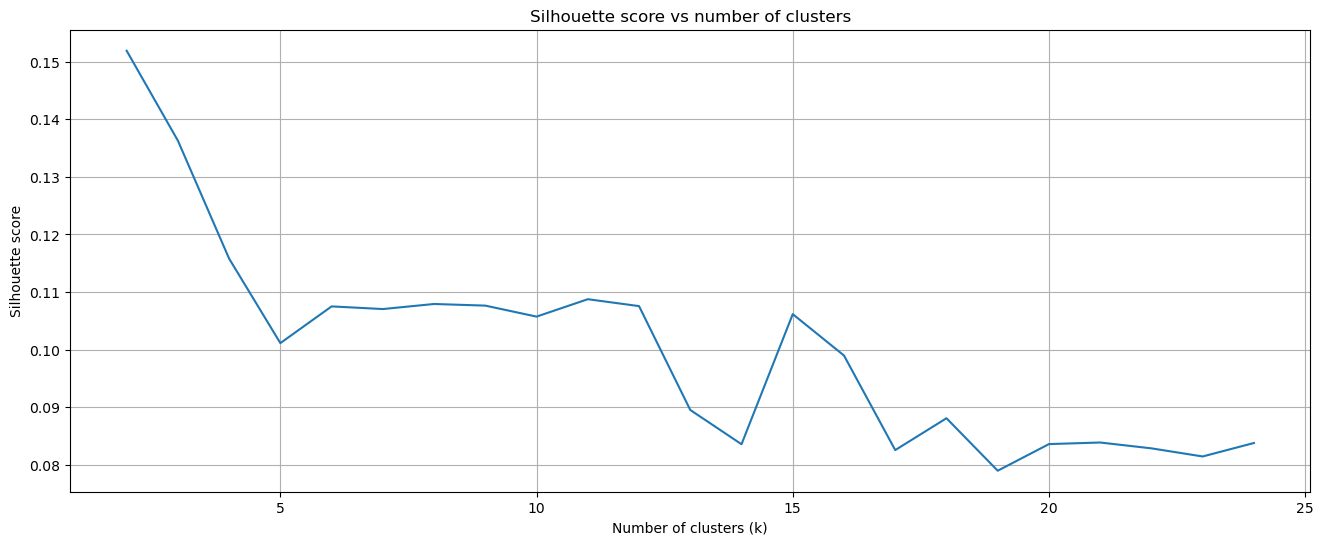

In [15]:
# Plot the silhouette scores against k values
plt.figure(figsize=(16, 6))
plt.plot(possible_k_values, silhouette_per_k)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.grid(True)
plt.show()

In [16]:
# Get the optimal number of clusters by finding the 'k' value that gives the highest silhouette score
optimal_k = possible_k_values[np.argmax(silhouette_per_k)]
print(f'Optimal number of clusters: {optimal_k}')

Optimal number of clusters: 2


In [17]:
# Create a new kmeans model with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, n_init=10).fit(candidates_wirtschaft_emb)

# Get the cluster predictions for the data
predictions_optimal = kmeans_optimal.predict(candidates_wirtschaft_emb)

# Create a dictionary mapping from word index to its assigned cluster
index_to_cluster = dict(zip(candidates_wirtschaft_int, predictions_optimal))

# Find the cluster that contains the word 'Wirtschaft'
wirtschaft_cluster = index_to_cluster[vocab_to_int['wirtschaft']]

# Get all words that belong to the 'wirtschaft' cluster
wirtschaft_synonyms = [int_to_vocab[idx] for idx, cluster in index_to_cluster.items() if cluster == wirtschaft_cluster]

# Print out the number of synonyms
print("Number of synonyms:", len(wirtschaft_synonyms))

# Print out the synonyms
print(f'Synonyms for konjunktur: {wirtschaft_synonyms}')

Number of synonyms: 653
Synonyms for konjunktur: ['wirtschaft', 'wirtschaftliche', 'arbeitslosigkeit', 'wirtschaftlichen', 'wirtschaftspolitik', 'wirtschafts', 'industrie', 'arbeitsmarktes', 'finanzpolitik', 'reformen', 'unternehmern', 'wirtschaftspolitischen', 'bdi', 'stärker', 'beschäftigung', 'ökonomische', 'ökonomischen', 'dihk', 'wirtschaftspolitische', 'handelskammertages', 'privatwirtschaft', 'sorgen', 'arbeitsmarkts', 'defizite', 'sachverständigenrat', 'strukturelle', 'entwicklung', 'staatsfinanzen', 'staatsquote', 'handelskammertag', 'arbeitsmarktpolitik', 'marktwirtschaft', 'rahmenbedingungen', 'vollbeschäftigung', 'bdipräsident', 'arbeitsmarktreformen', 'ökonomie', 'steuersenkungen', 'finanz', 'diht', 'wirtschaftlicher', 'massenarbeitslosigkeit', 'wansleben', 'wirtschaftsverbände', 'steuerpolitik', 'wichtiger', 'schaffen', 'thumann', 'haushaltskonsolidierung', 'deregulierung', 'strukturwandel', 'stärkere', 'globalisierung', 'zunehmend', 'bürokratie', 'wirtschaftsweise', 'wir

In [18]:
# Determine the 100 words with the highest cosine similarity to 'Wirtschaft'
wirtschaft_synonyms_cosine_similarity = candidates_wirtschaft[:100]

# Print out the number of synonyms
print("Number of synonyms:", len(wirtschaft_synonyms_cosine_similarity))

# Print out the synonyms
print(f'Synonyms for wirtschaft: {wirtschaft_synonyms_cosine_similarity}')

Number of synonyms: 100
Synonyms for wirtschaft: ['wirtschaft', 'wirtschaftliche', 'arbeitslosigkeit', 'volkswirtschaft', 'wirtschaftlichen', 'arbeitsmarkt', 'wirtschaftspolitik', 'wirtschafts', 'wirtschaftswachstum', 'industrie', 'ökonomen', 'aufschwung', 'arbeitsmarktes', 'finanzpolitik', 'reformen', 'strukturreformen', 'weltwirtschaft', 'unternehmern', 'wirtschaftspolitischen', 'bdi', 'stärker', 'beschäftigung', 'ökonomische', 'ökonomischen', 'dihk', 'konjunkturprogramme', 'wirtschaftsforschung', 'dynamik', 'konjunktur', 'wirtschaftsexperten', 'binnennachfrage', 'wirtschaftspolitische', 'diw', 'wirtschaftsentwicklung', 'handelskammertages', 'privatwirtschaft', 'konjunkturprogramm', 'forschungsinstitute', 'sorgen', 'wirtschaftsforscher', 'wirtschaftskraft', 'arbeitsmarkts', 'oecd', 'wirtschaftsaufschwung', 'lohnpolitik', 'defizite', 'wachstumskräfte', 'sachverständigenrat', 'strukturelle', 'aufschwungs', 'ifw', 'wettbewerbsfähigkeit', 'entwicklung', 'staatsfinanzen', 'staatsquote', '

When it comes to generating synonyms for 'Wirtschaft' (economy), the situation inverts. The first methodology, inspired by Soto, produces a substantial list of synonyms, many of which tend to be too general. For instance, it includes words such as 'dieses' (this), 'trotz' (despite), and 'ebenso' (also). These terms, while not entirely irrelevant to economic discussions, are far too broad to serve as effective, context-specific synonyms for 'Wirtschaft'.

On the other hand, the second methodology, which relies on cosine similarity, delivers a more concise list of synonyms that more specifically represent the concept of the economy. This list may be shorter, but the terms it includes hold closer contextual ties to 'Wirtschaft', making them more suitable as synonyms in related discussions.

In [19]:
# Write the synonyms to a file
import codecs

with codecs.open("wirtschaft_synonyms.txt", "w", "utf-8") as f:
    for item in wirtschaft_synonyms_cosine_similarity:
        f.write("%s\n" % item)